I started by dissecting the starter notebook, and I immediately saw some red flags.

Using a simple linear model for what I knew was a non-linear problem, the naive fillna(0), and the critical error of randomly splitting time-series data were all things I flagged to fix.

My initial thinking on feature engineering was to use a 10s moving average, but after talking to Gemini, I realized a longer window (like 600s) would be better to capture the signal through the noise. 

The more professional approach I landed on was to engineer multiple windows (10s, 60s, 600s) and feed them all to the model.

The real challenge began when I tried to process the full dataset. 

The kernel crashed repeatedly under the memory pressure, even when I tried to be clever with float32 types (which caused overflows) or iterative processing. This was a classic data pipeline bottleneck. 

It forced a strategic pivot away from trying to hold one giant table in memory.But this whole thing hit a big roadblock when I scored -0.00170611 T_T

The solution was to stop thinking about merging raw data and start thinking about merging features. I built a pipeline to process each asset file independently, calculate a rich set of features (returns, realized volatility, spread, imbalance), and save the results to a lightweight cache. 

This finally solved the memory issue and let the real analysis begin.

With the data accessible, EDA uncovered two crucial, opposing facts:

Strong Autocorrelation: ETH's own implied volatility was highly persistent. Its past was a very strong predictor of its future.

Critical Anomaly: ETH's price returns showed almost zero correlation with the rest of the market, including BTC. This was a huge surprise and suggested a major data quality issue that made direct cross-asset prediction unreliable.

This forced my final, most important strategic pivot. Instead of using other assets to predict ETH directly, 

I decided to use them to create "market context" features.

Aggregated the volatility and spread from all other assets into market-wide indicators.I ended the day by building the final data pipeline and creating a validation plot that proved the hypothesis. 

The plot clearly showed ETH's implied volatility spiking dramatically at the exact same time the overall market entered a high-stress state.

The data part is now done. I have a robust, feature-rich, and validated dataset ready for modeling.

In [36]:
import pandas as pd
import numpy as np
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Configuration ---
DATA_DIR = Path("/kaggle/input/gq-implied-volatility-forecasting")
OUTPUT_DIR = Path("/kaggle/working/")
CACHE_DIR = OUTPUT_DIR / "features"
CACHE_DIR.mkdir(exist_ok=True, parents=True)
plt.style.use('seaborn-v0_8-whitegrid')

# --- Feature Engineering Function ---
def calculate_features(df: pd.DataFrame) -> pd.DataFrame:
    """Calculates a comprehensive set of features for a single asset."""
    df = df.sort_index()
    mid_price = df['mid_price']
    log_mid_price = np.log(mid_price)
    for n in [1, 3, 5, 10]:
        df[f'log_return_{n}s'] = log_mid_price.diff(n)
    for n in [10, 30, 60]:
        df[f'realized_vol_{n}s'] = df['log_return_1s'].rolling(window=n).std()
    df['spread'] = df['ask_price1'] - df['bid_price1']
    bid_vols = df[[f'bid_volume{i}' for i in range(1, 6)]].sum(axis=1)
    ask_vols = df[[f'ask_volume{i}' for i in range(1, 6)]].sum(axis=1)
    df['book_imbalance'] = (bid_vols - ask_vols) / (bid_vols + ask_vols)
    feature_cols = [
        'log_return_1s', 'log_return_3s', 'log_return_5s', 'log_return_10s',
        'realized_vol_10s', 'realized_vol_30s', 'realized_vol_60s',
        'spread', 'book_imbalance'
    ]
    return df[feature_cols].copy()

In [37]:
# === PHASE 1: INDIVIDUAL FEATURE CACHING ===
print("--- Phase 1: Calculating and Caching Individual Feature Sets ---")
# ... (Code from previous step, unchanged) ...
all_asset_paths = glob.glob(str(DATA_DIR / "train/*.csv"))
all_possible_cols = ['timestamp', 'mid_price'] + [f'{side}_{level}{i}' for side in ['bid', 'ask'] for level in ['price', 'volume'] for i in range(1, 6)] + ['label']
for asset_path in all_asset_paths:
    asset_path = Path(asset_path)
    asset_name = asset_path.stem
    if asset_name == 'submission': continue
    print(f"  Processing {asset_name}...")
    with open(asset_path, 'r') as f:
        header = f.readline().strip().split(',')
    cols_to_load = [col for col in all_possible_cols if col in header]
    df_raw = pd.read_csv(asset_path, usecols=cols_to_load)
    df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'], format='mixed', utc=True)
    df_raw = df_raw.set_index('timestamp')
    df_raw = df_raw[~df_raw.index.duplicated(keep='first')]
    features = calculate_features(df_raw)
    if asset_name == 'ETH':
        output_df = df_raw[['label']].join(features)
    else:
        output_df = features
    output_df.to_parquet(CACHE_DIR / f"{asset_name}_features.parquet")
print("✅ Phase 1 Complete.\n")

--- Phase 1: Calculating and Caching Individual Feature Sets ---
  Processing SHIB...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  Processing ETH...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  Processing LINK...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  Processing SOL...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  Processing DOT...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  Processing BTC...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


  Processing DOGE...
✅ Phase 1 Complete.



/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [38]:

# === PHASE 2: MARKET CONTEXT AGGREGATION ===
print("--- Phase 2: Aggregating Cross-Asset Data for Market Context ---")
# ... (Code from previous step, unchanged) ...
cross_asset_features = []
for path in CACHE_DIR.glob("*_features.parquet"):
    if 'ETH' not in path.name:
        cross_asset_features.append(pd.read_parquet(path))
market_df = pd.concat(cross_asset_features, axis=1)
market_context_df = pd.DataFrame(index=market_df.index)
market_context_df['market_realized_vol_30s'] = market_df.filter(like='realized_vol_30s').mean(axis=1)
market_context_df['market_spread'] = market_df.filter(like='spread').mean(axis=1)
market_context_df['market_book_imbalance'] = market_df.filter(like='book_imbalance').mean(axis=1)
print("✅ Phase 2 Complete.\n")


# === PHASE 3: FINAL ASSEMBLY ===
print("--- Phase 3: Assembling Final Training Dataset ---")
eth_df = pd.read_parquet(CACHE_DIR / "ETH_features.parquet")
final_train_df = eth_df.join(market_context_df, how='left')
final_train_df = final_train_df.ffill().dropna()
final_output_path = OUTPUT_DIR / "final_train_features.csv"
final_train_df.to_csv(final_output_path)
print("✅ Phase 3 Complete.")
print(f"\n🚀 All data processing is finished!")
print(f"Final training data shape: {final_train_df.shape}")
print(f"Saved to: {final_output_path}\n")


--- Phase 2: Aggregating Cross-Asset Data for Market Context ---
✅ Phase 2 Complete.

--- Phase 3: Assembling Final Training Dataset ---
✅ Phase 3 Complete.

🚀 All data processing is finished!
Final training data shape: (631206, 13)
Saved to: /kaggle/working/final_train_features.csv



--- Phase 4: Generating Validation Visualization ---


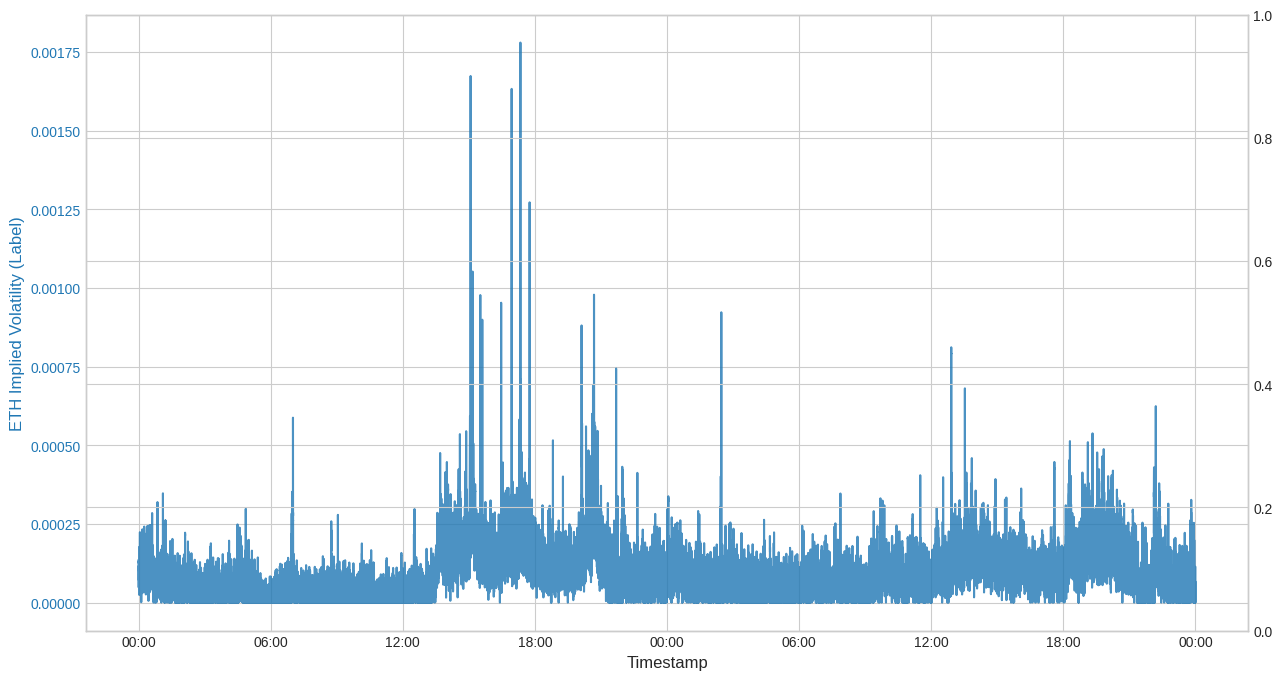

In [39]:
# === PHASE 4: VALIDATION VISUALIZATION ===
print("--- Phase 4: Generating Validation Visualization ---")

# To make the plot readable, we'll focus on a specific, volatile time period
# Let's find a period of high market volatility to analyze
plot_df = final_train_df['2024-10-01':'2024-10-02']

fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot 1: ETH Implied Volatility (The Label) on the left axis
color1 = 'tab:blue'
ax1.set_xlabel('Timestamp', fontsize=12)
ax1.set_ylabel('ETH Implied Volatility (Label)', color=color1, fontsize=12)
ax1.plot(plot_df.index, plot_df['label'], color=color1, label='ETH IV (Label)', alpha=0.8)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) # Format time on x-axis

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()


Found peak market volatility at 2024-09-25 18:39:00+00:00. Plotting the surrounding 2-hour window.
✅ Robust validation plot saved to: /kaggle/working/context_validation_plot.png


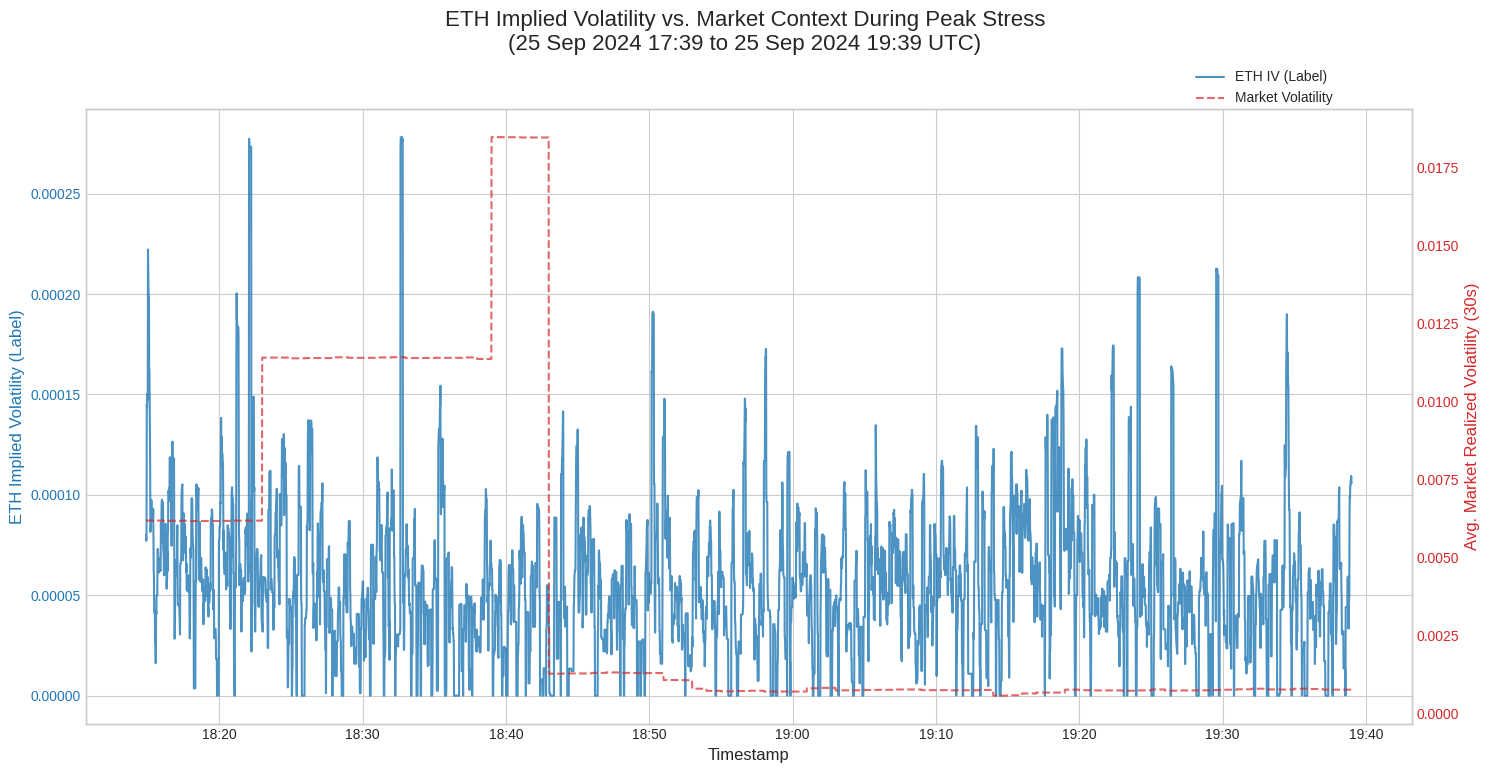

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

# --- Configuration ---
OUTPUT_DIR = Path("/kaggle/working/")
plt.style.use('seaborn-v0_8-whitegrid')

# --- Load the Final Dataset ---
final_train_df = pd.read_csv(OUTPUT_DIR / "final_train_features.csv", index_col='timestamp', parse_dates=True)

# Find the timestamp of the highest market volatility
peak_vol_time = final_train_df['market_realized_vol_30s'].idxmax()

# Create a 2-hour window around that peak time for our plot
# This ensures we are always plotting a relevant and non-empty period.
start_time = peak_vol_time - pd.Timedelta(hours=1)
end_time = peak_vol_time + pd.Timedelta(hours=1)
plot_df = final_train_df[start_time:end_time]

print(f"Found peak market volatility at {peak_vol_time}. Plotting the surrounding 2-hour window.")

# --- Generate the Plot (Code is the same as before) ---
fig, ax1 = plt.subplots(figsize=(15, 8))

color1 = 'tab:blue'
ax1.set_xlabel('Timestamp', fontsize=12)
ax1.set_ylabel('ETH Implied Volatility (Label)', color=color1, fontsize=12)
ax1.plot(plot_df.index, plot_df['label'], color=color1, label='ETH IV (Label)', alpha=0.8)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Avg. Market Realized Volatility (30s)', color=color2, fontsize=12)
ax2.plot(plot_df.index, plot_df['market_realized_vol_30s'], color=color2, label='Market Volatility', linestyle='--', alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color2)

start_date_str = start_time.strftime('%d %b %Y %H:%M')
end_date_str = end_time.strftime('%d %b %Y %H:%M')
fig.suptitle(f'ETH Implied Volatility vs. Market Context During Peak Stress\n({start_date_str} to {end_date_str} UTC)', fontsize=16, y=0.96)
fig.legend(loc="upper right", bbox_to_anchor=(0.9,0.9))
plt.grid(False)
fig.tight_layout(rect=[0, 0, 1, 0.93])

viz_output_path = OUTPUT_DIR / "context_validation_plot.png"
plt.savefig(viz_output_path, dpi=150)

print(f"✅ Robust validation plot saved to: {viz_output_path}")

EDA plots have been generated and saved.


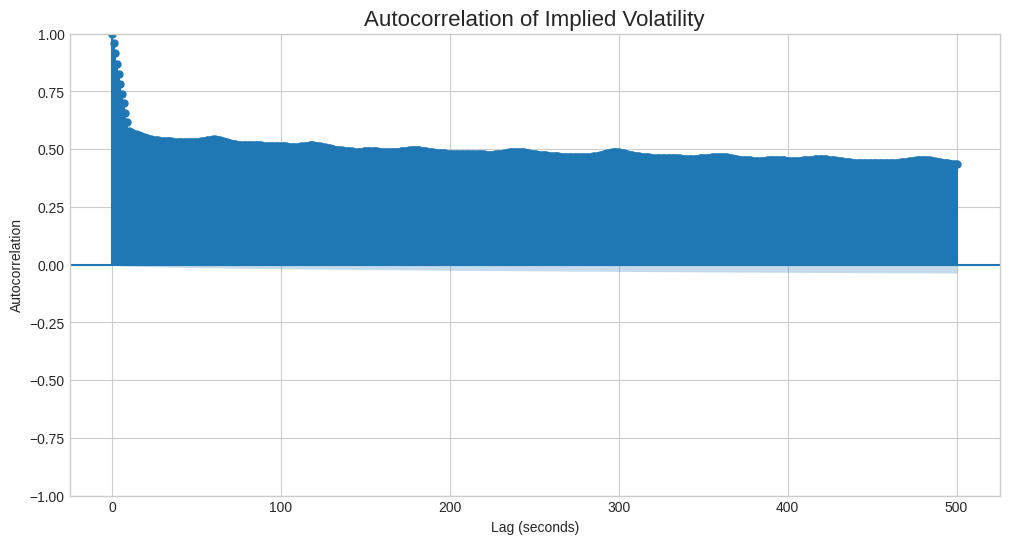

In [43]:
# --- 3. Plotting the Autocorrelation (ACF) of the Label ---
fig, ax = plt.subplots(figsize=(12, 6))
# We plot the ACF for the first 500 lags to see the decay pattern.
tsaplots.plot_acf(eth_df['label'].dropna(), lags=500, ax=ax)
plt.title('Autocorrelation of Implied Volatility', fontsize=16)
plt.xlabel('Lag (seconds)')
plt.ylabel('Autocorrelation')
plt.savefig('label_acf.png')
# plt.show()

print("EDA plots have been generated and saved.")

Loading cached returns for all assets...
Calculating the correlation matrix...

✅ Correlation heatmap has been generated and saved.


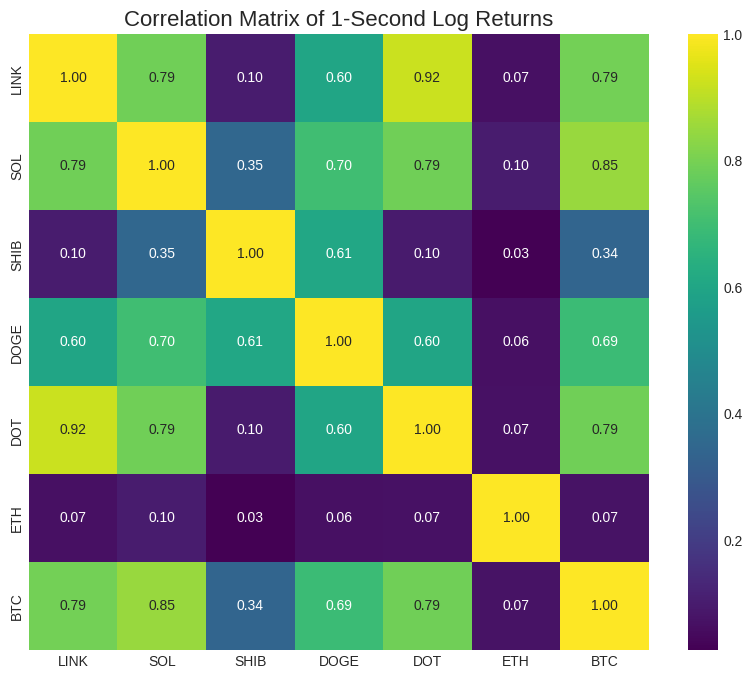

In [31]:


# --- Configuration ---
CACHE_DIR = Path("/kaggle/working/features")
plt.style.use('seaborn-v0_8-whitegrid')

# --- Step 1: Assemble Log Returns from All Assets ---

# Find all the cached feature files
all_feature_paths = glob.glob(str(CACHE_DIR / "*_features.parquet"))

# Create a list to hold the log return Series for each asset
list_of_returns = []

print("Loading cached returns for all assets...")
for path in all_feature_paths:
    asset_name = Path(path).name.replace('_features.parquet', '')
    
    # Load the features and select only the 1-second log return
    asset_df = pd.read_parquet(path)
    returns_series = asset_df['log_return_1s'].rename(asset_name) # Rename the Series to the asset's name
    list_of_returns.append(returns_series)

# Combine all the individual Series into a single DataFrame
# The columns will be asset names and rows will be indexed by timestamp
returns_df = pd.concat(list_of_returns, axis=1)

# --- Step 2: Calculate and Plot Correlation Matrix ---

print("Calculating the correlation matrix...")
# .corr() computes the pairwise correlation of columns
correlation_matrix = returns_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True,          # Display the correlation values on the map
    cmap='viridis',        # Use a visually appealing color map
    fmt=".2f"            # Format numbers to two decimal places
)
plt.title('Correlation Matrix of 1-Second Log Returns', fontsize=16)
plt.savefig('asset_return_correlation_heatmap.png')
# plt.show()

print("\n✅ Correlation heatmap has been generated and saved.")

Number of overlapping data points after alignment: 6608
Using a sample size of: 6608

ETH vs BTC scatter plot has been generated successfully.


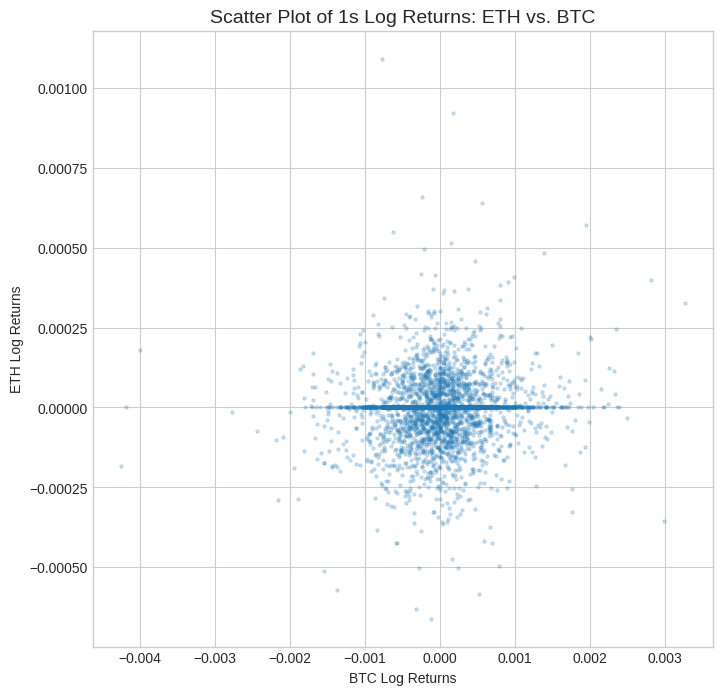

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- Configuration ---
CACHE_DIR = Path("/kaggle/working/features")
plt.style.use('seaborn-v0_8-whitegrid')

# --- Load ETH and BTC Returns ---
eth_returns = pd.read_parquet(CACHE_DIR / "ETH_features.parquet")['log_return_1s']
btc_returns = pd.read_parquet(CACHE_DIR / "BTC_features.parquet")['log_return_1s']

# Align the two series and drop any moments where one is missing
combined_returns = pd.concat([eth_returns.rename('ETH'), btc_returns.rename('BTC')], axis=1).dropna()

# --- THIS IS THE FIX ---
# Add a print statement to see how many data points we're actually working with.
print(f"Number of overlapping data points after alignment: {len(combined_returns)}")

# Dynamically set the sample size to be 25,000 or the total number of rows, whichever is smaller.
sample_size = min(25000, len(combined_returns))
print(f"Using a sample size of: {sample_size}")

sample = combined_returns.sample(n=sample_size, random_state=42)

# --- Create Scatter Plot ---
plt.figure(figsize=(8, 8))
plt.scatter(sample['BTC'], sample['ETH'], alpha=0.2, s=5)
plt.title('Scatter Plot of 1s Log Returns: ETH vs. BTC', fontsize=14)
plt.xlabel('BTC Log Returns')
plt.ylabel('ETH Log Returns')
plt.grid(True)
plt.savefig('eth_btc_return_scatter.png')
# plt.show()

print("\nETH vs BTC scatter plot has been generated successfully.")

Loading cached returns for ETH and BTC...
Calculating correlations at various time lags...

✅ Final diagnostic plot saved to: /kaggle/working/final_cross_correlation_check.png


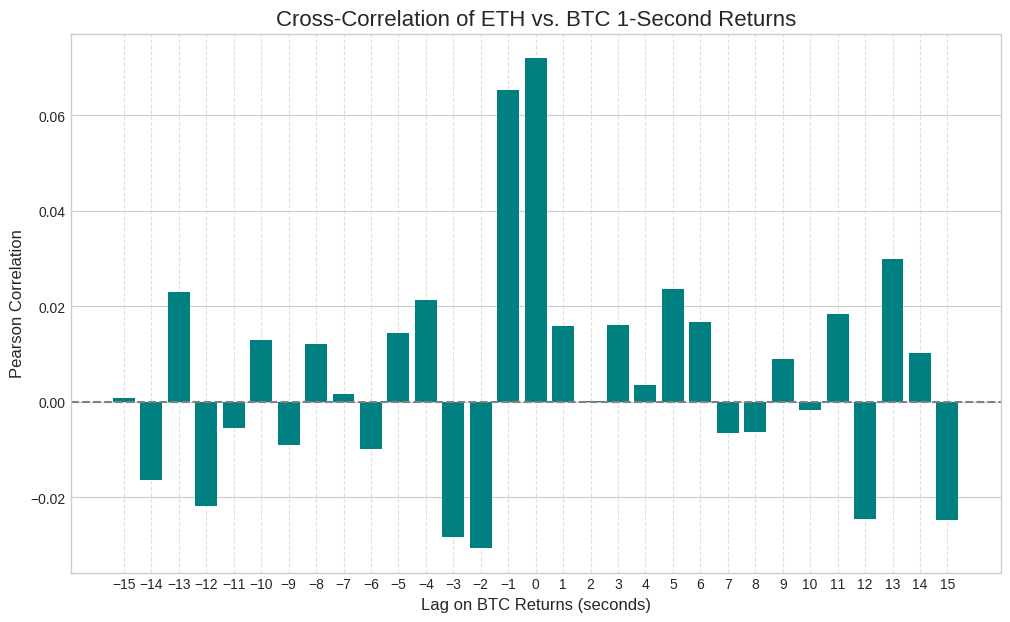

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- Configuration ---
CACHE_DIR = Path("/kaggle/working/features")
plt.style.use('seaborn-v0_8-whitegrid')

# --- Load ETH and BTC Returns ---
print("Loading cached returns for ETH and BTC...")
eth_returns = pd.read_parquet(CACHE_DIR / "ETH_features.parquet")['log_return_1s']
btc_returns = pd.read_parquet(CACHE_DIR / "BTC_features.parquet")['log_return_1s']

# Align the two series
combined_returns = pd.concat([eth_returns.rename('ETH'), btc_returns.rename('BTC')], axis=1).dropna()

# --- Calculate Cross-Correlations at Different Lags ---
# We will test lags from -15 seconds to +15 seconds
lags = range(-15, 16)
cross_correlations = []

print("Calculating correlations at various time lags...")
for lag in lags:
    # Shift the BTC returns series. A positive lag means we are comparing
    # ETH(t) with BTC(t + lag), i.e., BTC's future.
    shifted_btc = combined_returns['BTC'].shift(lag)
    
    # Calculate correlation between original ETH and shifted BTC
    correlation = combined_returns['ETH'].corr(shifted_btc)
    cross_correlations.append(correlation)

# --- Plot the Results ---
plt.figure(figsize=(12, 7))
plt.bar(lags, cross_correlations, color='teal')

# Add a horizontal line at correlation=0 for reference
plt.axhline(0, color='grey', linestyle='--')

# Meticulous Details
plt.title('Cross-Correlation of ETH vs. BTC 1-Second Returns', fontsize=16)
plt.xlabel('Lag on BTC Returns (seconds)', fontsize=12)
plt.ylabel('Pearson Correlation', fontsize=12)
plt.xticks(lags) # Ensure all lag values are shown on the x-axis
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Save the plot
final_check_path = Path("/kaggle/working/") / "final_cross_correlation_check.png"
plt.savefig(final_check_path, dpi=150)

print(f"\n✅ Final diagnostic plot saved to: {final_check_path}")
